# Handouts 3–4 demos (no FFT): integral intuition for the Fourier Transform

This notebook contains **live demos** designed to support Handout 3 (continuous spectrum, time–frequency trade-off) and Handout 4 (properties: shift, modulation, convolution, duality).

**Important:** we avoid FFTs to focus on meaning, rather than implementation. All spectra are computed by **numerical quadrature** (Riemann / trapezoidal approximation of the Fourier integral).

@2026, Flavia Mancini fm456@cam.ac.uk

---

## Conventions used here
We match our course convention:
$$
F(\omega)=\int_{-\infty}^{\infty} f(t)\,e^{-j\omega t}\,dt,\qquad
f(t)=\frac{1}{2\pi}\int_{-\infty}^{\infty} F(\omega)\,e^{j\omega t}\,d\omega.
$$

Since we cannot integrate to $\pm\infty\$ on a computer, we:
- choose a **time window** $$-T_\text{win}/2,\,T_\text{win}/2,$$
- sample time densely,
- approximate the integral with `np.trapz`.

This matches the “integral as a weighted sum” interpretation.

---


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Callable, Tuple, Optional

# ============================================================
# Fourier Transform (course convention)
#   F(ω) = ∫ f(t) e^{-jωt} dt
#   f(t) = (1/2π) ∫ F(ω) e^{jωt} dω
# Numerical quadrature on finite windows using trapezoids.
# ============================================================

@dataclass(frozen=True)
class Grid:
    """Uniform grid for numerical quadrature."""
    x: np.ndarray  # grid points
    dx: float      # spacing

def make_time_grid(Twin: float = 10.0, N: int = 4001) -> Grid:
    if N < 2:
        raise ValueError("N must be >= 2.")
    t = np.linspace(-Twin/2, Twin/2, N, dtype=np.float64)
    return Grid(t, float(t[1] - t[0]))

def make_omega_grid(Wmax: float = 60.0, M: int = 2001) -> Grid:
    if M < 2:
        raise ValueError("M must be >= 2.")
    w = np.linspace(-Wmax, Wmax, M, dtype=np.float64)
    return Grid(w, float(w[1] - w[0]))

def sinc_rad(x: np.ndarray) -> np.ndarray:
    """sin(x)/x with a stable definition at x=0 (radians)."""
    x = np.asarray(x, dtype=np.float64)
    out = np.ones_like(x)
    m = np.abs(x) > 1e-12
    out[m] = np.sin(x[m]) / x[m]
    return out

def ft_integral(
    f_t: np.ndarray,
    t: np.ndarray,
    w: np.ndarray,
    batch: int = 512,
    dtype=np.complex128,
) -> np.ndarray:
    """
    Numerical FT by trapezoidal rule:
        F(ω) = ∫ f(t) e^{-jωt} dt

    Uses batching over ω to avoid allocating a full (len(w) × len(t)) matrix.
    """
    t = np.asarray(t, dtype=np.float64)
    w = np.asarray(w, dtype=np.float64)
    f_t = np.asarray(f_t, dtype=dtype)

    if f_t.shape != t.shape:
        raise ValueError(f"f_t.shape {f_t.shape} must match t.shape {t.shape}")

    F = np.empty(w.shape, dtype=dtype)
    # Precompute dt for trapezoid in time
    # np.trapz uses nonuniform x too, but here t is uniform.
    for i0 in range(0, w.size, batch):
        ww = w[i0:i0+batch]
        expo = np.exp(-1j * ww[:, None] * t[None, :]).astype(dtype, copy=False)
        integrand = f_t[None, :] * expo
        F[i0:i0+batch] = np.trapz(integrand, t, axis=1)
    return F

def ift_integral(
    F_w: np.ndarray,
    w: np.ndarray,
    t: np.ndarray,
    batch: int = 512,
    dtype=np.complex128,
) -> np.ndarray:
    """
    Numerical inverse FT by trapezoidal rule:
        f(t) = (1/2π) ∫ F(ω) e^{jωt} dω

    Uses batching over t to avoid huge matrices.
    """
    t = np.asarray(t, dtype=np.float64)
    w = np.asarray(w, dtype=np.float64)
    F_w = np.asarray(F_w, dtype=dtype)

    if F_w.shape != w.shape:
        raise ValueError(f"F_w.shape {F_w.shape} must match w.shape {w.shape}")

    f = np.empty(t.shape, dtype=dtype)
    for i0 in range(0, t.size, batch):
        tt = t[i0:i0+batch]
        expo = np.exp(1j * tt[:, None] * w[None, :]).astype(dtype, copy=False)
        integrand = expo * F_w[None, :]
        f[i0:i0+batch] = (1/(2*np.pi)) * np.trapz(integrand, w, axis=1)
    return f

def mag_phase(F: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Magnitude and unwrapped phase."""
    F = np.asarray(F)
    return np.abs(F), np.unwrap(np.angle(F))

def cumulative_trapz(y: np.ndarray, x: np.ndarray) -> np.ndarray:
    y = np.asarray(y, dtype=np.complex128)
    x = np.asarray(x, dtype=np.float64)
    if y.shape != x.shape:
        raise ValueError("y and x must have the same shape")

    dx = np.diff(x)  # length N-1
    areas = 0.5 * (y[:-1] + y[1:]) * dx  # length N-1 (complex)

    out = np.empty_like(y, dtype=np.complex128)
    out[0] = 0.0 + 0.0j
    out[1:] = np.cumsum(areas)
    return out

print("Ready.")


Ready.


## Demo 1 — The FT as a rotating vector sum (phasor walk)

**Goal:** the integral is a sum of tiny complex vectors.

We compute partial integrals
$$
F(\omega; t_\text{end}) = \int_{-T_\text{win}/2}^{t_\text{end}} f(t)e^{-j\omega t}\,dt
$$
and plot the trajectory in the complex plane.

### Reflect on..
1. What does the path look like when $\omega$ matches a frequency in the signal?
2. What changes if we double $\omega$?
3. Why does “wrong $\omega$” cause cancellation?


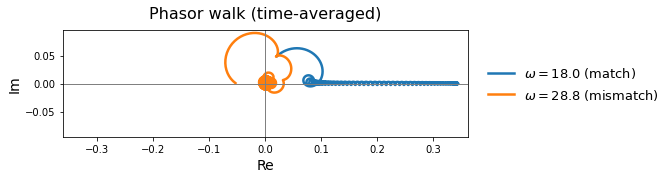

In [42]:
# Time axis
tg = make_time_grid(Twin=12.0, N=6001)
t = tg.x

# Signal: real tone (better geometry than a single complex exponential)
w0 = 18.0
f_t = np.cos(w0 * t) * np.exp(-0.5 * (t/3)**2)

# Frequencies to test
w_match = w0
w_wrong = 1.6 * w0

# Integrands for partial Fourier integrals
integrand_match = f_t * np.exp(-1j * w_match * t)
integrand_wrong = f_t * np.exp(-1j * w_wrong * t)

# Normalise partial integrals (time-averaged phasor sum)
tau = t - t[0]

Fp_match_n = Fp_match[1:] / tau[1:]
Fp_wrong_n = Fp_wrong[1:] / tau[1:]

fig, ax = plt.subplots(figsize=(9, 9))

ax.plot(Fp_match_n.real, Fp_match_n.imag, lw=2.5,
        label=rf"$\omega={w_match:.1f}$ (match)")
ax.plot(Fp_wrong_n.real, Fp_wrong_n.imag, lw=2.5,
        label=rf"$\omega={w_wrong:.1f}$ (mismatch)")

ax.axhline(0, color="gray", lw=1)
ax.axvline(0, color="gray", lw=1)

ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("Re", fontsize=14)
ax.set_ylabel("Im", fontsize=14)
ax.set_title("Phasor walk (time-averaged)", fontsize=16, pad=12)

# Square limits from actual data
xs = np.concatenate([Fp_match_n.real, Fp_wrong_n.real])
ys = np.concatenate([Fp_match_n.imag, Fp_wrong_n.imag])

xlim = 1.05 * np.max(np.abs(xs))
ylim = 1.05 * np.max(np.abs(ys))

ax.set_xlim(-xlim, xlim)
ax.set_ylim(-ylim, ylim)
ax.set_aspect("equal", adjustable="box")

# Legend on the side
fig.subplots_adjust(right=0.75)
ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5),
          frameon=False, fontsize=13)

plt.show()


# ------------------------------------------------------------
# This figure visualises the Fourier integral as a *vector sum*
# in the complex plane.
#
# Each curve shows the *partial Fourier integral*
#
#     ∫_{t_min}^{τ} f(t) e^{-jωt} dt
#
# (or its time-averaged version), traced as τ increases.
#
# • When ω matches a frequency component present in f(t),
#   the complex exponential compensates the signal oscillation:
#   successive vectors add coherently and the phasor drifts
#   away from the origin toward a stable direction.
#
# • When ω does not match, the integrand rotates in phase:
#   vectors point in many directions and largely cancel,
#   producing a bounded loop near the origin.
#
# This geometric cancellation explains why |F(ω)| is large
# at frequencies present in the signal and small elsewhere.
# ------------------------------------------------------------

## Demo 2 — Continuous spectrum from a finite-duration signal (rectangle → sinc)

**Goal:** finite-duration, non-periodic signals produce **continuous** spectra.

Signal:
$$
f(t)=\begin{cases}
1, & |t|<T/2\\
0, & \text{otherwise}
\end{cases}
$$
Theory (shape):
$$
F(\omega)=T\,\mathrm{sinc}\!\left(\frac{\omega T}{2}\right)
\quad\text{with }\mathrm{sinc}(x)=\sin x/x.
$$

### Reflect on...
1. Why isn’t the spectrum discrete?
2. What time-domain feature causes the sinc side-lobes?
3. What happens to the spectrum if we halve the pulse width?


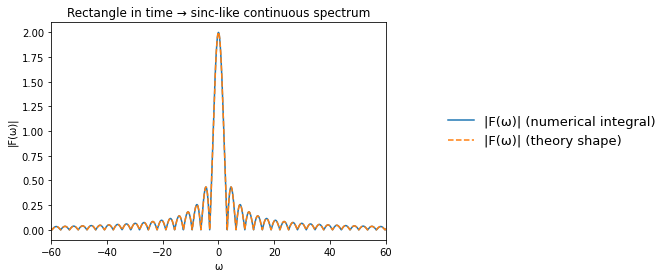

In [43]:
t, dt = setup_time(Twin=12.0, N=6001)
w, dw = setup_omega(Wmax=80.0, M=3001)

T_pulse = 2.0
f_rect = (np.abs(t) < T_pulse/2).astype(float)

F_num = ft_integral(f_rect, t, w)
F_theory = T_pulse * sinc(w*T_pulse/2)

plt.figure()
plt.plot(w, np.abs(F_num), label="|F(ω)| (numerical integral)")
plt.plot(w, np.abs(F_theory), "--", label="|F(ω)| (theory shape)")
plt.xlim(-60, 60)
plt.xlabel("ω"); plt.ylabel("|F(ω)|")
plt.title("Rectangle in time → sinc-like continuous spectrum")
plt.legend(
    loc="center left",
    bbox_to_anchor=(1.15, 0.5),
    frameon=False,
    fontsize=13
)
plt.show()


# ------------------------------------------------------------
# Continuous-spectrum demo: rectangular pulse → sinc spectrum
#
# We compute the Fourier transform of a *finite-duration* signal
# using the defining Fourier integral (numerical quadrature),
# not an FFT.
#
# The time-domain signal is a rectangular pulse of width T_pulse.
# Theory predicts:
#
#     rectangle in time  ↔  sinc-shaped spectrum in frequency
#
# The numerical result (solid line) approximates the exact
# Fourier integral over a finite time window.
# The dashed curve shows the theoretical sinc envelope for comparison.
#
# Key points to notice:
# • The spectrum is continuous (not discrete).
# • Narrower time localisation → broader frequency content.
# • The oscillatory sidelobes arise from sharp edges in time.
#
# This illustrates both the time–frequency trade-off and the
# origin of sinc spectra from abrupt time truncation.
# ------------------------------------------------------------

## Demo 3 — Time shift changes phase, not magnitude

Property:
$$
f(t-t_0)\ \longleftrightarrow\ F(\omega)e^{-j\omega t_0}.
$$

### Reflect on..
1. If you delay a signal in time, why shouldn’t its frequency content change?
2. Why are higher frequencies more sensitive to delay?
3. Can you estimate $t_0$ from the phase slope?


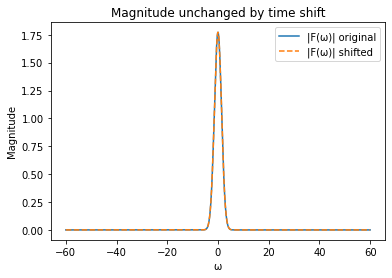

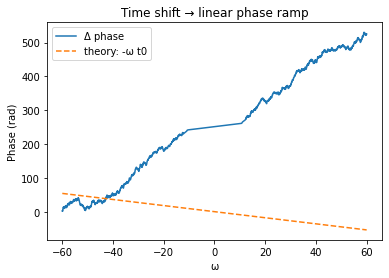

In [44]:
t, dt = setup_time(Twin=12.0, N=6001)
w, dw = setup_omega(Wmax=60.0, M=2001)

sigma = 1.0
f0 = np.exp(-(t/sigma)**2)

t0 = 0.9
f_shift = np.interp(t, t - t0, f0, left=0.0, right=0.0)

F0 = ft_integral(f0, t, w)
F1 = ft_integral(f_shift, t, w)

mag0, ph0 = mag_phase(F0)
mag1, ph1 = mag_phase(F1)

plt.figure()
plt.plot(w, mag0, label="|F(ω)| original")
plt.plot(w, mag1, "--", label="|F(ω)| shifted")
plt.xlabel("ω"); plt.ylabel("Magnitude")
plt.title("Magnitude unchanged by time shift")
plt.legend()
plt.show()

plt.figure()
plt.plot(w, ph1 - ph0, label="Δ phase")
plt.plot(w, -w*t0, "--", label="theory: -ω t0")
plt.xlabel("ω"); plt.ylabel("Phase (rad)")
plt.title("Time shift → linear phase ramp")
plt.legend()
plt.show()

# ------------------------------------------------------------
# Time-shift property of the Fourier Transform
#
# We start with a Gaussian pulse f0(t), which is well-localised
# in both time and frequency.
#
# We then form a time-shifted version:
#     f_shift(t) = f0(t - t0)
#
# According to the Fourier Transform time-shift theorem:
#
#     f(t - t0)  ↔  F(ω) e^{-jωt0}
#
# Predictions:
# • The magnitude spectrum |F(ω)| is unchanged by a time shift.
# • The phase spectrum acquires a linear ramp:  -ω t0.
#
# In the plots below:
# • The first figure confirms that |F(ω)| is identical before
#   and after the shift.
# • The second figure shows that the phase difference between
#   the two spectra follows the predicted straight line.
#
# This demonstrates that:
#   → time shifts affect *phase only*, not frequency content.
# ------------------------------------------------------------


## Demo 4 — Modulation shifts the spectrum (no FFT)

For cosine modulation:
$$
f(t)\cos(\omega_0 t)\ \longleftrightarrow\ \tfrac12F(\omega-\omega_0)+\tfrac12F(\omega+\omega_0).
$$

### Reflect on...
1. Why do we get *two* shifted copies?
2. What sets the shape of each copy?
3. How would you choose \(\omega_0\) to avoid overlap?


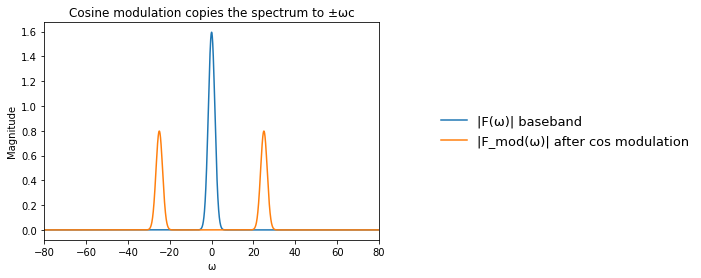

In [45]:
t, dt = setup_time(Twin=12.0, N=6001)
w, dw = setup_omega(Wmax=80.0, M=3001)

sigma = 0.9
f = np.exp(-(t/sigma)**2)

w_c = 25.0
f_mod = f * np.cos(w_c*t)

F = ft_integral(f, t, w)
Fmod = ft_integral(f_mod, t, w)

plt.figure()
plt.plot(w, np.abs(F), label="|F(ω)| baseband")
plt.plot(w, np.abs(Fmod), label="|F_mod(ω)| after cos modulation")
plt.xlim(-80, 80)
plt.xlabel("ω"); plt.ylabel("Magnitude")
plt.title("Cosine modulation copies the spectrum to ±ωc")
plt.legend(
    loc="center left",
    bbox_to_anchor=(1.15, 0.5),
    frameon=False,
    fontsize=13
)
plt.show()


# ------------------------------------------------------------
# Frequency-shift (modulation) property of the Fourier Transform
#
# We start with a Gaussian signal f(t), whose spectrum F(ω)
# is centred at ω = 0 (baseband).
#
# We then modulate the signal by a cosine:
#     f_mod(t) = f(t) cos(ωc t)
#
# Using the identity:
#     cos(ωc t) = (1/2)[e^{jωc t} + e^{-jωc t}]
#
# the modulation theorem predicts:
#
#     f(t) cos(ωc t)
#       ↔ (1/2)[F(ω - ωc) + F(ω + ωc)]
#
# Predictions:
# • The original spectrum at ω = 0 is copied to ±ωc.
# • Each copy has half the amplitude.
# • The *shape* of the spectrum is preserved.
#
# In the plot below:
# • |F(ω)| is the original baseband spectrum.
# • |F_mod(ω)| shows two shifted copies at ±ωc.
#
# This is the basic mechanism of amplitude modulation in
# communication systems.
# ------------------------------------------------------------


## Demo 5 — Convolution theorem (integral version)

We check:
$$
\mathcal{F}\{f*g\}(\omega)\approx F(\omega)G(\omega)
$$
where the convolution $f*g$ is computed as a Riemann-sum approximation of the convolution integral.

### Reflect on...
1. Which is easier: convolution in time or multiplication in frequency?
2. If $g$ is a smoothing kernel, what happens to high frequencies?
3. How does the width of $g$ control the cutoff?


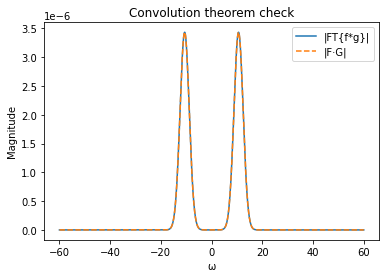

In [46]:
t, dt = setup_time(Twin=14.0, N=7001)
w, dw = setup_omega(Wmax=60.0, M=2001)

f = np.exp(-(t/0.6)**2) * np.cos(18*t)

sigma_g = 0.5
g = np.exp(-(t/sigma_g)**2)
g = g / np.trapz(g, t)  # area 1

# Convolution integral approximated by discrete convolution with dt scaling
h = np.convolve(f, g, mode="same") * dt

F = ft_integral(f, t, w)
G = ft_integral(g, t, w)
H_from_time = ft_integral(h, t, w)
H_from_freq = F * G

plt.figure()
plt.plot(w, np.abs(H_from_time), label="|FT{f*g}|")
plt.plot(w, np.abs(H_from_freq), "--", label="|F·G|")
plt.xlabel("ω"); plt.ylabel("Magnitude")
plt.title("Convolution theorem check")
plt.legend()
plt.show()

# ------------------------------------------------------------
# Convolution theorem: time-domain smoothing ↔ frequency-domain multiplication
#
# We start with a band-limited oscillatory signal f(t)
# (a cosine modulated by a Gaussian envelope).
#
# We then define g(t) as a narrow Gaussian kernel with unit area.
# Convolving f with g therefore performs *smoothing* (low-pass filtering)
# without changing the overall signal scale.
#
# Time-domain operation:
#     h(t) = (f * g)(t)
#
# Frequency-domain prediction (convolution theorem):
#     FT{f * g} = F(ω) · G(ω)
#
# In this demo we compute:
# • H_from_time  = FT of the convolved signal (directly from h(t))
# • H_from_freq  = product of the individual spectra F(ω) and G(ω)
#
# The two curves should match closely.
#
# Interpretation:
# • Convolution in time corresponds to multiplication in frequency.
# • The narrow Gaussian g(t) produces a broad G(ω),
#   which attenuates high-frequency components of F(ω).
#
# This is the mathematical basis of filtering:
# smoothing in time = low-pass filtering in frequency.
# ------------------------------------------------------------

## Effect of convolution on sounds (still no FFT)

We generate a short sound-like waveform (sum of tones), apply:
- an **echo** impulse response,
- a **smoothing** kernel (low-pass),
then estimate frequency content via a short-window Fourier **integral**.

### Reflect on...
1. What does echo do in time? What might it imply in frequency?
2. Why does smoothing remove “brightness” (high-frequency content)?
3. Where do you see the time–frequency trade-off?


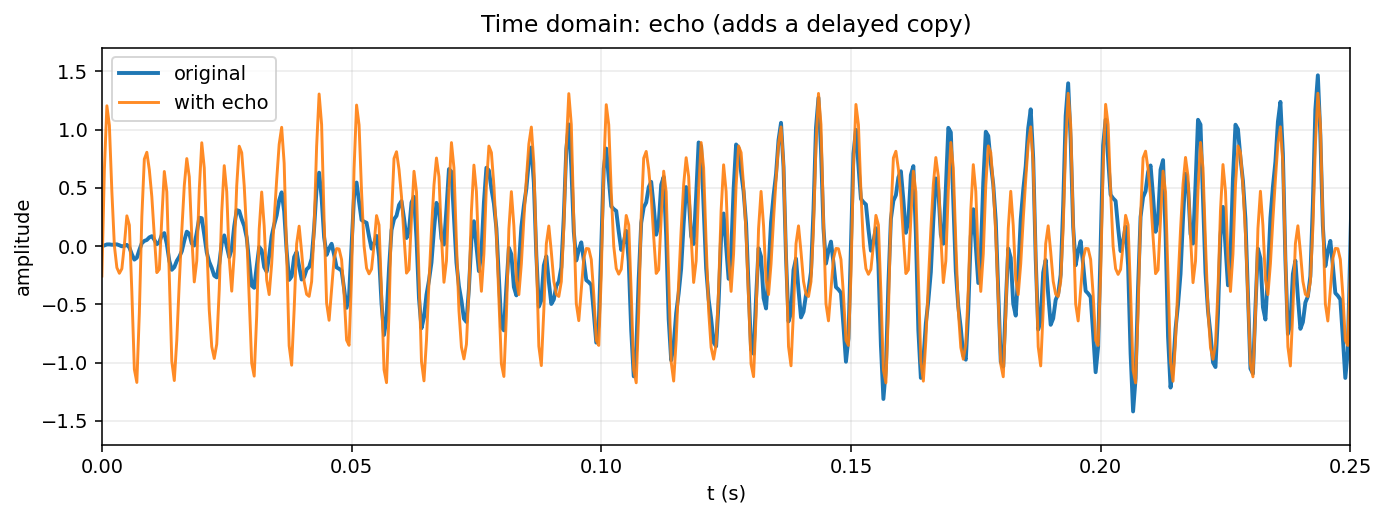

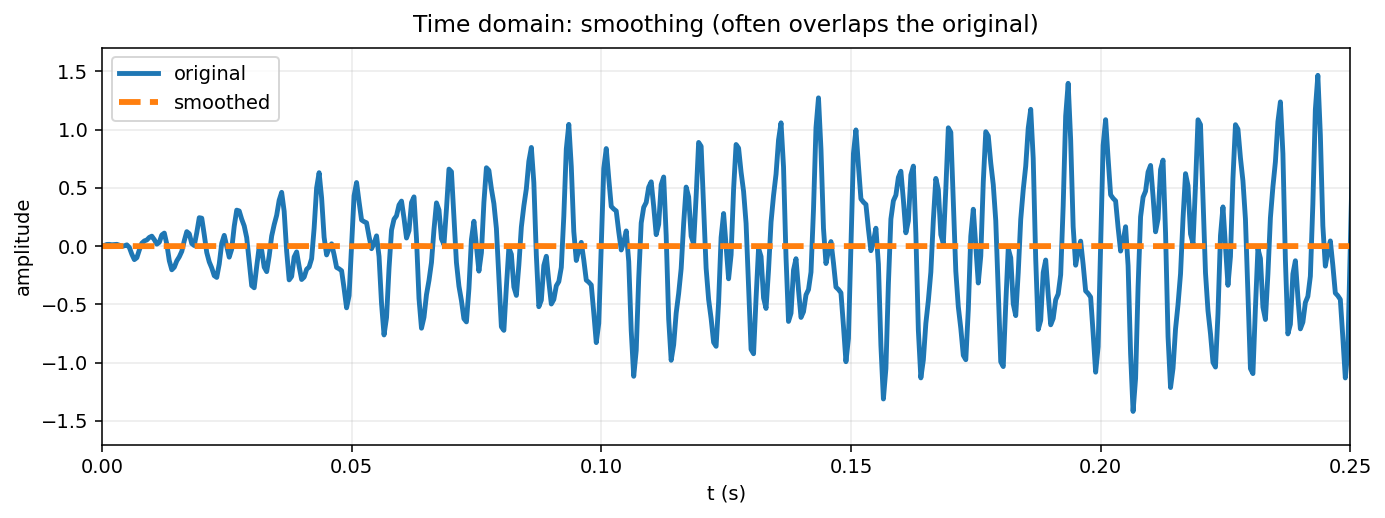

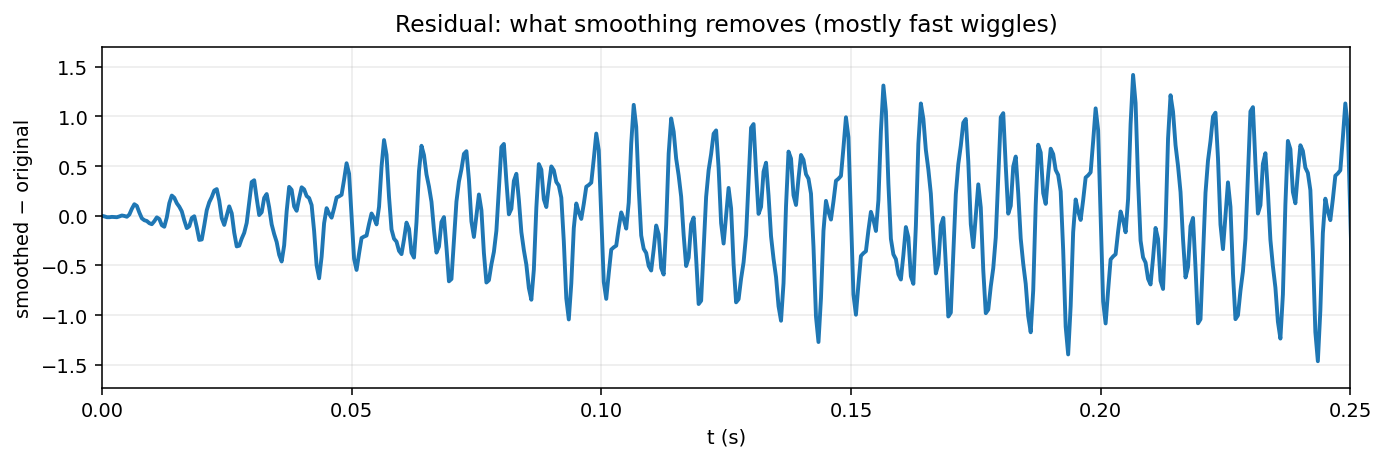

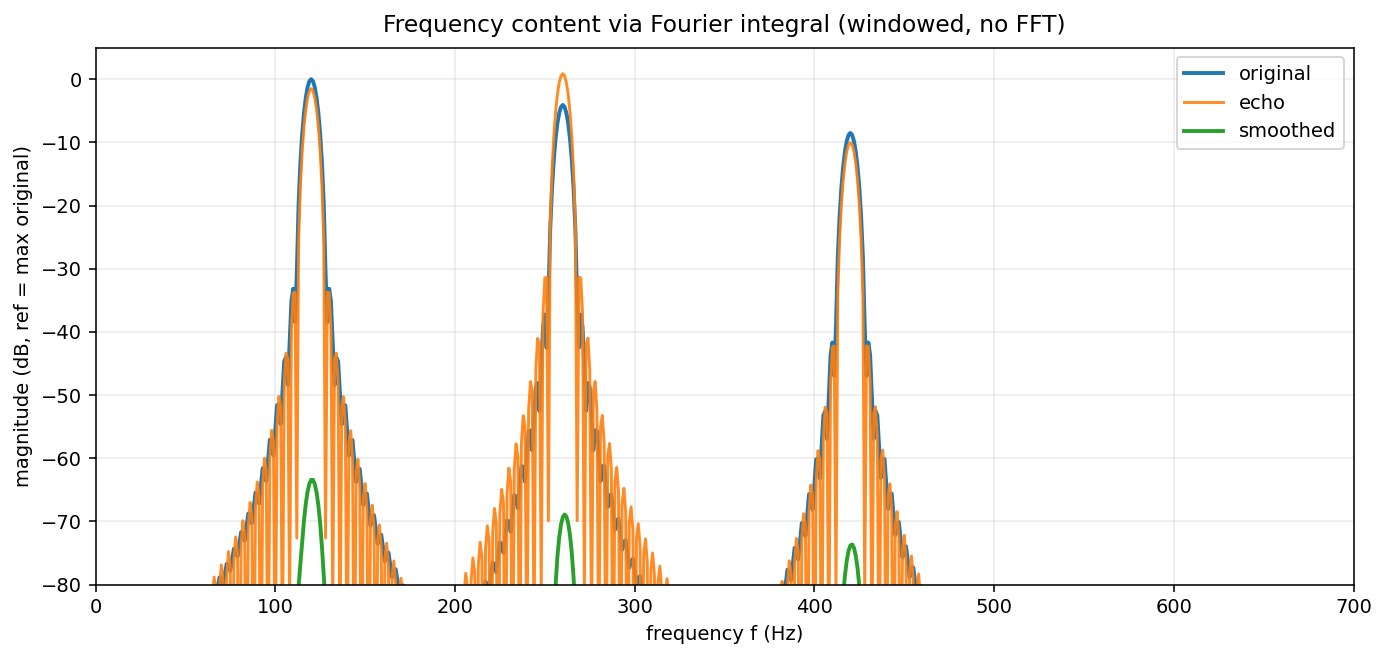

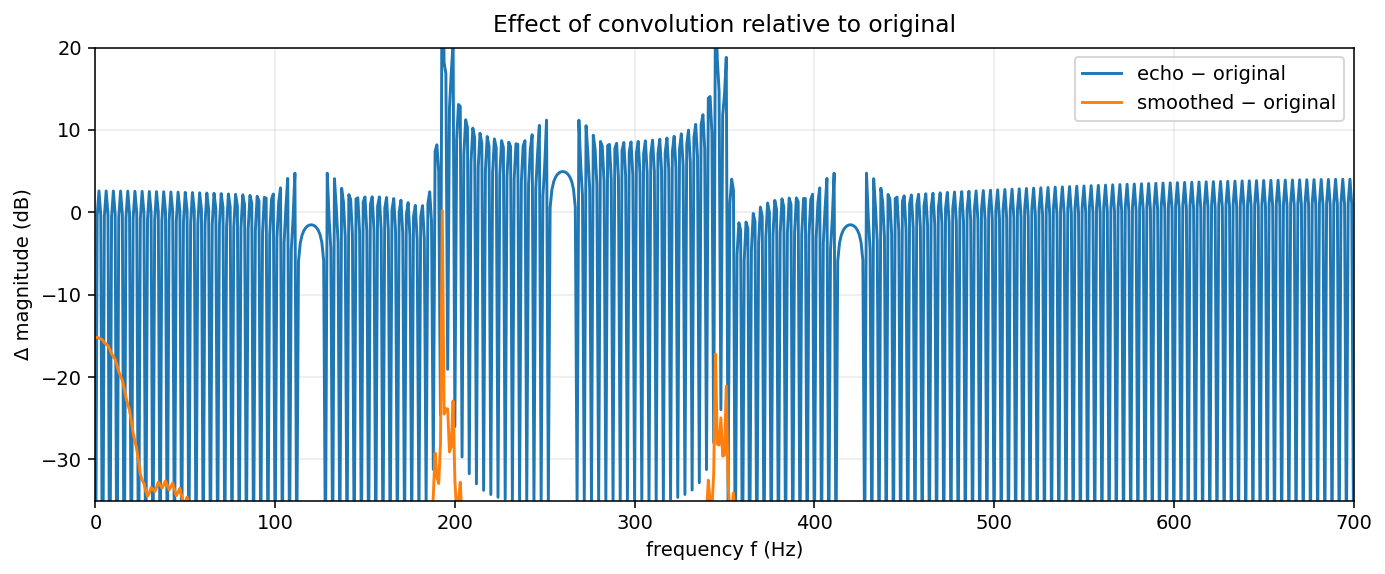

In [47]:
# ------------------------------------------------------------
# Demo: convolution on "sound-like" signals (echo vs smoothing) + spectra via the FT integral
#
# We build a short synthetic signal x(t) as a sum of 3 sinusoids:
#   120 Hz, 260 Hz, 420 Hz
# then apply an exponential "fade-in" envelope so the signal starts smoothly
# (reduces a sharp step at t=0, which would otherwise introduce extra high frequencies).
#
# We then apply two different impulse responses (two different linear systems):
#
# 1) Echo system: h_echo(t) = δ(t) + 0.6 δ(t - delay)
#    Convolution adds a delayed copy of the signal → audible/visible echo.
#
# 2) Smoothing system: gk(t) is a Gaussian kernel (unit-sum discrete approximation)
#    Convolution averages nearby samples → low-pass filtering / smoothing.
#
# Finally, we compare frequency content using a numerical approximation of the Fourier integral
# (not FFT): F(ω) ≈ ∫ f(t) e^{-jωt} dt over a finite time window.
#
# Cf. Handout 4: filtering = convolution in time, multiplication in frequency.
# ------------------------------------------------------------

# ------------------------------------------------------------
# Demo: convolution on "sound-like" signals (echo vs smoothing)
# + spectra via the Fourier integral (no FFT)
#
# Key teaching points:
# • Echo = delayed copy → comb-like spectral effects
# • Smoothing = local averaging → high-frequency attenuation
# ------------------------------------------------------------

# --- 1) Build a synthetic "sound-like" signal ---
fs_sound = 2000
dur_sound = 0.8
t_sound = np.linspace(0, dur_sound, int(fs_sound * dur_sound), endpoint=False)
dt_sound = t_sound[1] - t_sound[0]

x_sound = (0.8*np.sin(2*np.pi*120*t_sound) +
           0.5*np.sin(2*np.pi*260*t_sound) +
           0.3*np.sin(2*np.pi*420*t_sound))

# smooth fade-in envelope (reduces step at t=0)
x_sound *= (1 - np.exp(-12*t_sound))

# --- 2) Two impulse responses (echo vs smoothing) ---
delay_s = 0.08
delay_N = int(round(delay_s * fs_sound))
if delay_N >= len(t_sound):
    raise ValueError("Echo delay is longer than the signal length.")

# Echo impulse response
h_echo = np.zeros_like(t_sound)
h_echo[0] = 1.0
h_echo[delay_N] = 0.6

# Gaussian smoothing kernel (make it STRONGER so effect is visible)
klen = int(round(0.05 * fs_sound))
n = np.arange(-klen, klen+1)

sigma_samples = 0.030 * fs_sound   # <-- increased from 0.012
gk = np.exp(-(n/sigma_samples)**2)
gk = gk / np.sum(gk)               # unit-sum kernel

# Convolution
y_echo_sound   = np.convolve(x_sound, h_echo, mode="same")
y_smooth_sound = np.convolve(x_sound, gk, mode="same")

# --- 3) Time-domain plots (zoomed) ---
plt.figure(figsize=(10, 3.8), dpi=140)
plt.plot(t_sound, x_sound, label="original", linewidth=2)
plt.plot(t_sound, y_echo_sound, label="with echo", alpha=0.9)
plt.xlim(0, 0.25)
plt.xlabel("t (s)"); plt.ylabel("amplitude")
plt.title("Time domain: echo (adds a delayed copy)", pad=8)
plt.grid(alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 3.8), dpi=140)
plt.plot(t_sound, x_sound, label="original", linewidth=2.5)
plt.plot(t_sound, y_smooth_sound,
         label="smoothed", linewidth=3, linestyle="--")
plt.xlim(0, 0.25)
plt.xlabel("t (s)"); plt.ylabel("amplitude")
plt.title("Time domain: smoothing (often overlaps the original)", pad=8)
plt.grid(alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

# --- NEW: residual plot (THIS makes smoothing obvious) ---
plt.figure(figsize=(10, 3.4), dpi=140)
plt.plot(t_sound, y_smooth_sound - x_sound, linewidth=2)
plt.xlim(0, 0.25)
plt.xlabel("t (s)")
plt.ylabel("smoothed − original")
plt.title("Residual: what smoothing removes (mostly fast wiggles)", pad=8)
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

# --- 4) Spectrum via Fourier integral over a short window ---
Twin = 0.25
mask = (t_sound >= 0) & (t_sound <= Twin)

tt  = t_sound[mask]
xw  = x_sound[mask]
yew = y_echo_sound[mask]
ysw = y_smooth_sound[mask]

# Hann window reduces leakage
win = np.hanning(len(tt))
xw_w  = xw  * win
yew_w = yew * win
ysw_w = ysw * win

# Angular frequency axis
fmax = 800
M = 1601
w = np.linspace(-2*np.pi*fmax, 2*np.pi*fmax, M)
f_Hz = w / (2*np.pi)

X  = ft_integral(xw_w,  tt, w)
YE = ft_integral(yew_w, tt, w)
YS = ft_integral(ysw_w, tt, w)

# Convert to dB (reference = max of ORIGINAL)
eps = 1e-12
ref = np.max(np.abs(X)) + eps

XdB  = 20*np.log10(np.abs(X)/ref  + eps)
YEdB = 20*np.log10(np.abs(YE)/ref + eps)
YSdB = 20*np.log10(np.abs(YS)/ref + eps)

# --- 5) Spectra (positive frequencies only) ---
pos = f_Hz >= 0

plt.figure(figsize=(10, 4.8), dpi=140)
plt.plot(f_Hz[pos], XdB[pos],  label="original", linewidth=2)
plt.plot(f_Hz[pos], YEdB[pos], label="echo", alpha=0.9)
plt.plot(f_Hz[pos], YSdB[pos], label="smoothed", linewidth=2)

plt.xlim(0, 700)
plt.ylim(-80, 5)
plt.xlabel("frequency f (Hz)")
plt.ylabel("magnitude (dB, ref = max original)")
plt.title("Frequency content via Fourier integral (windowed, no FFT)", pad=8)
plt.grid(alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

# --- 6) Difference plot: always reveals the effect ---
plt.figure(figsize=(10, 4.2), dpi=140)
plt.plot(f_Hz[pos], (YEdB - XdB)[pos], label="echo − original")
plt.plot(f_Hz[pos], (YSdB - XdB)[pos], label="smoothed − original")

plt.xlim(0, 700)
plt.ylim(-35, 20)
plt.xlabel("frequency f (Hz)")
plt.ylabel("Δ magnitude (dB)")
plt.title("Effect of convolution relative to original", pad=8)
plt.grid(alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()


# Echo is y(t) = x(t) + a x(t-delay), so in frequency:
#   Y(ω) = X(ω) [1 + a e^{-jω delay}]
# The factor in brackets depends on ω, creating peaks/notches ("comb filtering").
# Smoothing uses a Gaussian-like kernel → low-pass behaviour (attenuates high frequencies).

# Time domain:
# • Echo: creates a clear second “copy” of features delayed by ~80 ms.
# • Smoothing: removes rapid wiggles (high-frequency components) while keeping the overall shape - so in time it can look unchanged.
